# Headline

Beschreibung

### Daten

## 1. EDA

#### Imports

In [296]:
# suppress matplotlib inline warnings
import warnings
warnings.filterwarnings("ignore")

from typing import Tuple, List, Dict
import json
import logging
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import cv2
from functools import reduce
from PIL import Image, ImageOps
from matplotlib import cm
import imgaug as ia
import imgaug.augmenters as iaa
from tensorflow import keras
from tensorflow.keras.models import *
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Input, concatenate, UpSampling2D, Conv2DTranspose
import tensorflow as tf
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import load_img
import keras.backend as K

import shapely
import matplotlib.pyplot as plt
from matplotlib.path import Path
%matplotlib inline

#### Config

In [229]:
logging.basicConfig(level=logging.INFO, format='%(levelname)s -  %(asctime)s: %(message)s')

# Setting up File Paths
RAW_DATA_PATH = '../data/raw'
PREPPED_DATA_PATH = '../data/prepped'

dirname = os.getcwd()
filename_val_bounding_boxes = os.path.join(dirname, RAW_DATA_PATH, 'val/via_region_data.json')
filename_train_bounding_boxes = os.path.join(dirname, RAW_DATA_PATH, 'train/via_region_data.json')

#### Loading Ground Truth

In [230]:
logging.info("Test")

INFO -  2022-03-15 10:26:38,499: Test


In [231]:
with open(filename_train_bounding_boxes, 'r') as f:
  train_bounding_boxes = json.load(f)

Check number of entries

In [232]:
len(train_bounding_boxes)

52

In [233]:
train_bounding_boxes

{'test_pattern_qbist.jpg129855': {'fileref': '',
  'size': 129855,
  'filename': 'test_pattern_qbist.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'a_swan_swimming_in_geneve_lake.jpg62201': {'fileref': '',
  'size': 62201,
  'filename': 'a_swan_swimming_in_geneve_lake.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'sinus_test_pattern.jpg27894': {'fileref': '',
  'size': 27894,
  'filename': 'sinus_test_pattern.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {}},
 'image67.jpg47277': {'fileref': '',
  'size': 47277,
  'filename': 'image67.jpg',
  'base64_img_data': '',
  'file_attributes': {},
  'regions': {'0': {'shape_attributes': {'name': 'polygon',
     'all_points_x': [298, 327, 346, 369, 522, 512, 488, 393, 307, 288, 298],
     'all_points_y': [199, 203, 241, 265, 246, 290, 320, 322, 318, 264, 199]},
    'region_attributes': {'name': 'damage'}},
   '1': {'shape_attributes': {'name': 'polygon',
     'all_

In [234]:
train_df = pd.DataFrame.from_dict(train_bounding_boxes)
train_df = train_df.transpose().reset_index()
# Remove first three rows as they contain images that are not actually in the dataset
train_df = train_df.iloc[3: , :].reset_index(drop=True)

In [235]:
train_df.head()

,index,fileref,size,filename,base64_img_data,file_attributes,regions
0,image67.jpg47277,,47277,image67.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
1,image66.jpg19024,,19024,image66.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
2,image65.jpg102144,,102144,image65.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
3,image64.jpg85335,,85335,image64.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."
4,image63.jpg24447,,24447,image63.jpg,,{},"{'0': {'shape_attributes': {'name': 'polygon',..."


Check data for duplicates.

In [236]:
sum(train_df.duplicated(subset=['index','filename']))

0

Calculate average image size.

In [237]:
train_df['size'].mean()

137704.306122449

Columns fileref, size, base64_img_data and file_attributes where identified to be either empty or not relevant to the given task and were therfore dropped to simplify the dataframe.

In [238]:
train_df = train_df.drop(['index', 'fileref', 'size', 'base64_img_data', 'file_attributes'], axis=1)

In [239]:
train_df.head()

,filename,regions
0,image67.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
1,image66.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
2,image65.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
3,image64.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."
4,image63.jpg,"{'0': {'shape_attributes': {'name': 'polygon',..."


Expand 'regions' dict to examine structure of the training data.

In [240]:
 train_df['regions'].apply(pd.Series).head()

,0,1,2,3,4
0,"{'shape_attributes': {'name': 'polygon', 'all_...","{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN
1,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
2,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
3,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN
4,"{'shape_attributes': {'name': 'polygon', 'all_...",NaN,NaN,NaN,NaN


In [241]:
 train_df['regions'].apply(pd.Series)['0'][23]

{'shape_attributes': {'name': 'polygon',
  'all_points_x': [226, 175, 160, 164, 174, 189, 197, 218, 236, 226],
  'all_points_y': [62, 139, 178, 202, 207, 181, 138, 117, 80, 62]},
 'region_attributes': {'name': 'damage'}}

Analyse the maximum number of points used for the polygon throughout the dataset.

In [242]:
resolution_of_polygons = []

for row in train_df['regions']:
    for region in row.values():
        resolution_of_polygons.append(len(region['shape_attributes']['all_points_x']))

print(f'Maximum number of polygons used: {max(resolution_of_polygons)}')
print(f'Average number of polygons used: {sum(resolution_of_polygons) / len(resolution_of_polygons)}')

Maximum number of polygons used: 33
Average number of polygons used: 13.602564102564102


#### Displaying Examples for Bounding Boxes from the Training Set

In [243]:
def show_bounding_box(regions: dict, img_path: str)-> None:
    image = cv2.imread(img_path)
    isClosed = True
    color = (255,23,200)
    thickness = 3
        
    regions = list(regions)
    # remove nan from list
    regions = [x for x in regions if str(x) != 'nan']

    # draw polygon for all regions
    for region in regions:
        x = region['shape_attributes']['all_points_x']
        y = region['shape_attributes']['all_points_y']

        poly = np.array(list(zip(x, y)), np.int32)
            
        cv2.polylines(image, [poly], isClosed, color, thickness)
    
    plt.imshow(image)
    plt.show()

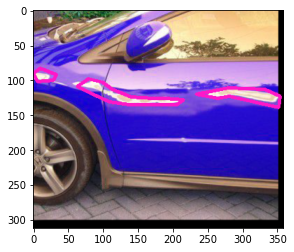

In [244]:
SAMPLE_INDEX = 43

show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, RAW_DATA_PATH, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

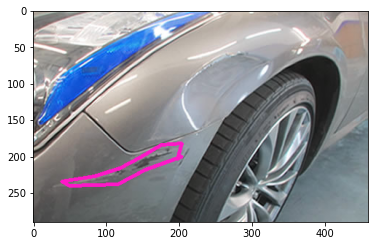

In [245]:
SAMPLE_INDEX = 5

show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, RAW_DATA_PATH, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

## 2. Data Preperation

#### Loading Ground Truth

In [246]:
def load_ground_truth(path: str, filename: str = 'via_region_data.json') -> pd.DataFrame:
    with open(os.path.join(path, filename), 'r') as f:
        ground_truth = json.load(f)
        ground_truth = pd.DataFrame.from_dict(ground_truth)

        ground_truth = ground_truth.transpose().reset_index()
        ground_truth = ground_truth.iloc[3: , :].reset_index(drop=True)

        ground_truth = ground_truth.drop(['index', 'fileref', 'size', 'base64_img_data', 'file_attributes'], axis=1)
    return ground_truth

#### Creating masks from Polygons

Retrieve image dimensions for images

In [247]:
def get_image_dimensions(img_path: str) -> Tuple[int, int]:
    img = cv2.imread(img_path)
    return img.shape[:2]

Turn polygons into image masks

In [248]:
def get_mask_from_poly(dimensions: Tuple[int, int], regions: Dict[str, List]) -> np.ndarray:
    x, y = np.mgrid[:dimensions[0], :dimensions[1]]
    coors=np.hstack((x.reshape(-1, 1), y.reshape(-1,1)))
    
    masks = []

    for region in regions.values():
        poly = list(zip(region['shape_attributes']['all_points_y'], region['shape_attributes']['all_points_x']))
        poly_path=Path(poly)

        masks.append(poly_path.contains_points(coors))
        
    full_mask = reduce(np.logical_or, masks)
    return full_mask.reshape(dimensions[0], dimensions[1])

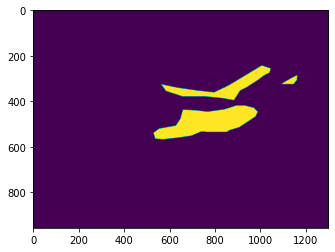

In [249]:
# TESTING
SAMPLE_INDEX = 24

reg = train_df.loc[SAMPLE_INDEX]['regions']
folder_path = os.path.join(dirname, RAW_DATA_PATH, 'train')
img_dim = get_image_dimensions(os.path.join(folder_path, train_df.loc[SAMPLE_INDEX]['filename']))

plt.imshow(get_mask_from_poly(img_dim, reg))
plt.show()

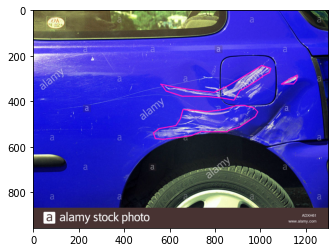

In [250]:
show_bounding_box(regions=train_df['regions'].apply(pd.Series).loc[SAMPLE_INDEX], 
                  img_path=os.path.join(dirname, RAW_DATA_PATH, 'train', train_df['filename'].loc[SAMPLE_INDEX]))

In [251]:
def generate_masks(df: pd.DataFrame, read_path: str) -> List[np.ndarray]:

    masks = []
    dimensions = []

    for index, row in df.iterrows():
        img_dim = get_image_dimensions(os.path.join(read_path, row['filename']))
        masks.append(get_mask_from_poly(img_dim, row['regions']))
        dimensions.append(img_dim)
    
    return masks, dimensions

#### Resize images and masks

In [252]:
def resize_image_and_mask(row: pd.Series, targetSize: int, readPath: str, writePath: str) -> np.ndarray:

    if not (os.path.isfile(os.path.join(writePath, row['filename'])) and os.path.isfile(os.path.join(writePath, 'mask_' + row['filename']))):
        img = Image.open(os.path.join(readPath, row['filename'])).convert('RGB')
        mask = Image.fromarray(row['mask']).convert('L')

        wpercent = (targetSize/float(img.size[0]))
        hsize = int((float(img.size[1])*float(wpercent)))

        img_resized = img.resize((targetSize, hsize), Image.LANCZOS)
        mask_resized = mask.resize((targetSize, hsize), Image.LANCZOS)

        padded_img.imwrite(os.path.join(writePath, 'images', row['filename']))
        # .png for lossless files
        mask_resized.save(os.path.join(writePath, 'masks', row['filename'] + ".png"), compress_level=0, optimize=False)
    else:
        logging.debug('Resized image and mask already exist.')
        img_resized = Image.open(os.path.join(writePath, 'images', row['filename']))
        mask_resized = Image.open(os.path.join(writePath, 'masks', row['filename'] + ".png"))
    
    return img_resized, mask_resized 

In [253]:
def resize_image_and_mask(row: pd.Series, targetSize: int, readPath: str, writePath: str) -> np.ndarray:

    if not (os.path.isfile(os.path.join(writePath, row['filename'])) and os.path.isfile(os.path.join(writePath, 'mask_' + row['filename']))):
        img = cv2.imread(os.path.join(readPath, row['filename']))
        mask = Image.fromarray(row['mask']).convert('L')
        mask = np.array(mask)

        f1 = 400 / img.shape[1]
        f2 = 400 / img.shape[0]
        f = min(f1, f2) 
        dim = (int(img.shape[1] * f), int(img.shape[0] * f))
        img_resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)

        mask_resized = cv2.resize(mask, dim, interpolation = cv2.INTER_AREA)

        padded_img = cv2.copyMakeBorder(img_resized, 0, 400 - img_resized.shape[0], 0, 400 - img_resized.shape[1], cv2.BORDER_REFLECT)
        padded_mask = cv2.copyMakeBorder(mask_resized, 0, 400 - mask_resized.shape[0], 0, 400 - mask_resized.shape[1], cv2.BORDER_REFLECT)

        padded_img = Image.fromarray(padded_img)
        padded_img.save(os.path.join(writePath, 'images', row['filename']))
        # .png for lossless files
        padded_mask = Image.fromarray(padded_mask)
        padded_mask.save(os.path.join(writePath, 'masks', row['filename'] + ".png"), compress_level=0, optimize=False)
    else:
        logging.debug('Resized image and mask already exist.')
        padded_img = Image.open(os.path.join(writePath, 'images', row['filename']))
        padded_mask = Image.open(os.path.join(writePath, 'masks', row['filename'] + ".png"))
    
    return padded_img, padded_mask 

In [254]:
# # TESTING
# read_path = os.path.join(dirname, RAW_DATA_PATH, 'train')
# write_path = os.path.join(dirname, PREPPED_DATA_PATH, 'train_resized')

# resize_image_and_mask(training_data.loc[40], 300, read_path, write_path)

Normalize Inputs

#### Data Augmentation

In [255]:
seq = iaa.Sequential([
    iaa.CropAndPad(percent=(-0.2, 0.2), pad_mode="reflect"), #crop
    iaa.Fliplr(0.5), # flip
	iaa.Affine(rotate=(-25, 25)), # rotate
	iaa.AdditiveGaussianNoise(scale=(5, 20)), # noise
	iaa.AddToHueAndSaturation((-10, 20)),  # change color
    iaa.GaussianBlur(sigma=(0, 1.0)) # blur 
], random_order=True)


def augment_seg( img , seg  ):
	
	aug_det = seq.to_deterministic() 
	image_aug = aug_det.augment_image( img )

	seg = np.array(seg)

	segmap = ia.SegmentationMapOnImage( seg , nb_classes=np.max(seg)+1 , shape=img.shape )
	segmap_aug = aug_det.augment_segmentation_maps( segmap )
	segmap_aug = segmap_aug.get_arr_int()

	return image_aug , segmap_aug

In [256]:
# mask = cv2.imread(r"C:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\data\prepped\val\masks\mask_image78.jpg.png")
# img = cv2.imread(r"C:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\data\prepped\val\images\image78.jpg")

# plt.imshow(img)
# plt.show()

# plt.imshow(mask)
# plt.show()

# print(type(mask))

# image_aug , segmap_aug = augment_seg(img , mask)

# plt.imshow(image_aug)
# plt.show()

# plt.imshow(segmap_aug)
# plt.show()

In [257]:
def generate_augmentations(img, mask, row: pd.Series, path : str, no_augments: int  = 5):
    # convert from PIL to CV2
    img = np.array(img) 
    # img = img[:, :, ::-1].copy() 
    mask = np.array(mask) 
    # mask = mask[:, :, ::-1].copy() 
    
    augmentations = [augment_seg(img, mask) for _ in range(no_augments)]

    for index, aug in enumerate(augmentations):
        cv2.imwrite(os.path.join(path, 'images', row['filename'] + f'_aug_{index}.png'), aug[0]) # image
        cv2.imwrite(os.path.join(path, 'masks',  row['filename'] + f'_aug_{index}.png'), aug[1]) # mask

#### Data Prep Pipeline

In [258]:
def run_pipeline(target_size, no_augmentations, subdir: str) -> pd.DataFrame:

    input_path = os.path.join(dirname, RAW_DATA_PATH, subdir)
    output_path = os.path.join(dirname, PREPPED_DATA_PATH, subdir)

    logging.info('Pipeline started.')
    logging.info(f'Input path: {input_path}')
    logging.info(f'Output path: {output_path}')
    
    logging.info('Loading ground truth.')
    df = load_ground_truth(input_path)

    logging.info('Creating masks.')
    df['mask'], df['dimensions'] = generate_masks(df, read_path = input_path)

    logging.info('Resizing images and masks and saving them.')
    for index, row in tqdm(df.iterrows(), total=df.shape[0]):
        img_resized, mask_resized = resize_image_and_mask(row, target_size, input_path, output_path)
        generate_augmentations(img_resized, mask_resized, row, output_path, no_augments=no_augmentations)

    logging.info('Pipeline done.')
    return df

In [259]:
TARGET_SIZE = 256

training_data = run_pipeline(TARGET_SIZE, 0, subdir='train')

INFO -  2022-03-15 10:26:44,791: Pipeline started.
INFO -  2022-03-15 10:26:44,792: Input path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/raw\train
INFO -  2022-03-15 10:26:44,793: Output path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/prepped\train
INFO -  2022-03-15 10:26:44,793: Loading ground truth.
INFO -  2022-03-15 10:26:44,799: Creating masks.
INFO -  2022-03-15 10:26:52,236: Resizing images and masks and saving them.
100%|██████████| 49/49 [00:01<00:00, 47.22it/s]
INFO -  2022-03-15 10:26:53,394: Pipeline done.


In [260]:
validation_data = run_pipeline(TARGET_SIZE, 0, subdir= 'val')

INFO -  2022-03-15 10:26:53,523: Pipeline started.
INFO -  2022-03-15 10:26:53,525: Input path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/raw\val
INFO -  2022-03-15 10:26:53,526: Output path: c:\Users\Max\Documents\VS Code Projects\MB_Mobility_DamageDetection\notebooks\../data/prepped\val
INFO -  2022-03-15 10:26:53,526: Loading ground truth.
INFO -  2022-03-15 10:26:53,535: Creating masks.
INFO -  2022-03-15 10:26:54,498: Resizing images and masks and saving them.
100%|██████████| 12/12 [00:00<00:00, 74.56it/s]
INFO -  2022-03-15 10:26:54,661: Pipeline done.


In [72]:
training_data.head()

,filename,regions,mask,dimensions
0,image67.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(518, 690)"
1,image66.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(225, 300)"
2,image65.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(538, 634)"
3,image64.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(411, 962)"
4,image63.jpg,"{'0': {'shape_attributes': {'name': 'polygon',...","[[False, False, False, False, False, False, Fa...","(423, 544)"


## 3. Training the Classifier

Train-Test-Split was already taken care of.

#### Test 2

In [261]:
IMG_SHAPE = 256

In [262]:
def normalize(image, mask):
  image = tf.cast(image, tf.float32) / 255.0
  mask = mask / 255
  return image, mask

def load_and_preprocess(img_filepath, mask_filepath):
    img = tf.io.read_file(img_filepath)
    img = tf.io.decode_jpeg(img, channels=3)

    mask = tf.io.read_file(mask_filepath)
    mask = tf.io.decode_png(mask, channels=1)

    img, mask = normalize(img, mask)

    return img, mask

In [263]:
input_img_paths_train = [os.path.join(dirname, '../data/prepped/train/images') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/train/images/')) ]
annotation_img_paths_train = [os.path.join(dirname, '../data/prepped/train/masks') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/train/masks/'))]

input_img_paths_val = [os.path.join(dirname, '../data/prepped/val/images') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/val/images/')) ]
annotation_img_paths_val = [os.path.join(dirname, '../data/prepped/val/masks') +'/'+ s for s in os.listdir(os.path.join(dirname, '../data/prepped/val/masks/'))]

In [264]:
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 12

trainloader = tf.data.Dataset.from_tensor_slices((input_img_paths_train, annotation_img_paths_train))
testloader = tf.data.Dataset.from_tensor_slices((input_img_paths_val, annotation_img_paths_val))

trainloader = (
    trainloader
    .shuffle(1024)
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

testloader = (
    testloader
    .map(load_and_preprocess, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

In [265]:
class SegmentationModel:
  '''
  Build UNET like model for image inpaining task.
  '''
  def prepare_model(self, OUTPUT_CHANNEL, input_size=(IMG_SHAPE,IMG_SHAPE,3)):
    inputs = Input(input_size)


    # Encoder 
    conv1, pool1 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', inputs) 
    conv2, pool2 = self.__ConvBlock(64, (3,3), (2,2), 'relu', 'same', pool1)
    conv3, pool3 = self.__ConvBlock(128, (3,3), (2,2), 'relu', 'same', pool2) 
    conv4, pool4 = self.__ConvBlock(256, (3,3), (2,2), 'relu', 'same', pool3) 
    
    # Decoder
    conv5, up6 = self.__UpConvBlock(512, 256, (3,3), (2,2), (2,2), 'relu', 'same', pool4, conv4)
    conv6, up7 = self.__UpConvBlock(256, 128, (3,3), (2,2), (2,2), 'relu', 'same', up6, conv3)
    conv7, up8 = self.__UpConvBlock(128, 64, (3,3), (2,2), (2,2), 'relu', 'same', up7, conv2)
    conv8, up9 = self.__UpConvBlock(64, 32, (3,3), (2,2), (2,2), 'relu', 'same', up8, conv1)
    
    conv9 = self.__ConvBlock(32, (3,3), (2,2), 'relu', 'same', up9, False)
    
    # Notice OUTPUT_CHANNEL and activation
    outputs = Conv2D(OUTPUT_CHANNEL, (3, 3), activation='softmax', padding='same')(conv9)


    return Model(inputs=[inputs], outputs=[outputs])  


  def __ConvBlock(self, filters, kernel_size, pool_size, activation, padding, connecting_layer, pool_layer=True):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    if pool_layer:
      pool = MaxPooling2D(pool_size)(conv)
      return conv, pool
    else:
      return conv


  def __UpConvBlock(self, filters, up_filters, kernel_size, up_kernel, up_stride, activation, padding, connecting_layer, shared_layer):
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(connecting_layer)
    conv = Conv2D(filters=filters, kernel_size=kernel_size, activation=activation, padding=padding)(conv)
    up = Conv2DTranspose(filters=up_filters, kernel_size=up_kernel, strides=up_stride, padding=padding)(conv)
    up = concatenate([up, shared_layer], axis=3)


    return conv, up

#### Test 3

In [338]:
class Dataset(keras.utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""
    

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths
        self.img_size = (256,256)

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            thresh = 100
            fn = lambda x : 255 if x > thresh else 0
            img = img.convert('L').point(fn, mode='1')
            img = np.asarray(img) * -1
            # y[j] = img
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1
        return x, y

    def processing(self, img):
        img = img / 255.0
        
        return img

In [351]:
from tensorflow.keras import layers

img_size_target = 256
num_classes = 2

def build_model(input_layer, start_neurons):
    # 128 -> 64
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    # 64 -> 32
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    # 32 -> 16
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    # 16 -> 8
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    # 8 -> 16
    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    # 16 -> 32
    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    # 32 -> 64
    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    # 64 -> 128
    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    #uconv1 = Dropout(0.5)(uconv1)
    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size_target, img_size_target, 3))
output_layer = build_model(input_layer, 16)

model = Model(input_layer, output_layer)

In [357]:
batch_size = 32
img_size = (256,256)

train_gen = Dataset(
    batch_size, img_size, input_img_paths_train, annotation_img_paths_train
)
val_gen = Dataset(batch_size, img_size, input_img_paths_val, annotation_img_paths_val)

In [358]:
opt = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_104 (Conv2D)            (None, 256, 256, 16  448         ['input_8[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_105 (Conv2D)            (None, 256, 256, 16  2320        ['conv2d_104[0][0]']             
                                )                                                           

In [359]:
# early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint("./keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

history = model.fit(train_gen, epochs=10, validation_data=val_gen, callbacks=[model_checkpoint], class_weight={0: 0.1, 1: 1})

ValueError: `class_weight` not supported for 3+ dimensional targets.

In [ ]:
val_gen = Dataset(batch_size, (256,256), input_img_paths_val, annotation_img_paths_val)

In [ ]:
val_preds = model.predict(val_gen[0][0])


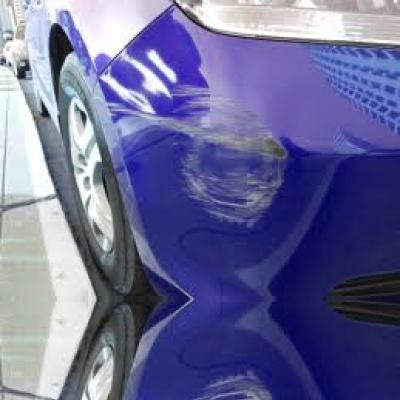

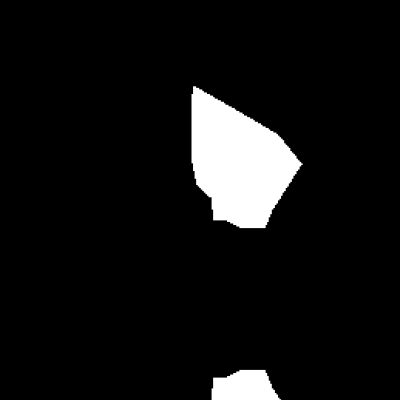

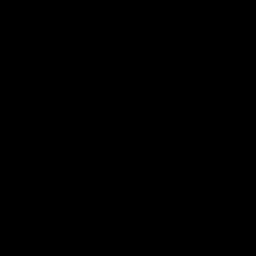

In [ ]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 5

# Display input image
display(Image(filename=input_img_paths_val[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(annotation_img_paths_val[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

In [ ]:
callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

modelHist = model.fit(trainloader, 
              epochs=15, 
              validation_data=testloader,
              callbacks=callbacks)

Epoch 1/15


InvalidArgumentError:  Conv2DCustomBackpropInput: Size of out_backprop doesn't match computed: actual = 25, computed = 16 spatial_dim: 1 input: 32 filter: 3 output: 25 stride: 2 dilation: 1
	 [[node model_5/conv2d_transpose_24/conv2d_transpose
 (defined at C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\backend.py:5530)
]] [Op:__inference_train_function_222187]

Errors may have originated from an input operation.
Input Source operations connected to node model_5/conv2d_transpose_24/conv2d_transpose:
In[0] model_5/conv2d_transpose_24/stack (defined at C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\layers\convolutional.py:1333)	
In[1] model_5/conv2d_transpose_24/conv2d_transpose/ReadVariableOp:	
In[2] model_5/conv2d_94/Relu (defined at C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\backend.py:4867)

Operation defined at: (most recent call last)
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\runpy.py", line 197, in _run_module_as_main
>>>     return _run_code(code, main_globals, None,
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\runpy.py", line 87, in _run_code
>>>     exec(code, run_globals)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
>>>     app.launch_new_instance()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
>>>     app.start()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\kernelapp.py", line 677, in start
>>>     self.io_loop.start()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
>>>     self.asyncio_loop.run_forever()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\asyncio\base_events.py", line 596, in run_forever
>>>     self._run_once()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\asyncio\base_events.py", line 1890, in _run_once
>>>     handle._run()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\asyncio\events.py", line 80, in _run
>>>     self._context.run(self._callback, *self._args)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 457, in dispatch_queue
>>>     await self.process_one()
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 446, in process_one
>>>     await dispatch(*args)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 353, in dispatch_shell
>>>     await result
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\kernelbase.py", line 648, in execute_request
>>>     reply_content = await reply_content
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\ipkernel.py", line 353, in do_execute
>>>     res = shell.run_cell(code, store_history=store_history, silent=silent)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\ipykernel\zmqshell.py", line 533, in run_cell
>>>     return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
>>>     result = self._run_cell(
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
>>>     return runner(coro)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
>>>     coro.send(None)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
>>>     has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
>>>     if (await self.run_code(code, result,  async_=asy)):
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
>>>     exec(code_obj, self.user_global_ns, self.user_ns)
>>> 
>>>   File "C:\Users\Max\AppData\Local\Temp/ipykernel_14356/4021467791.py", line 5, in <module>
>>>     modelHist = model.fit(trainloader,
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1216, in fit
>>>     tmp_logs = self.train_function(iterator)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 878, in train_function
>>>     return step_function(self, iterator)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 867, in step_function
>>>     outputs = model.distribute_strategy.run(run_step, args=(data,))
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 860, in run_step
>>>     outputs = model.train_step(data)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 808, in train_step
>>>     y_pred = self(x, training=True)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 451, in call
>>>     return self._run_internal_graph(
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\functional.py", line 589, in _run_internal_graph
>>>     outputs = node.layer(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\base_layer.py", line 1083, in __call__
>>>     outputs = call_fn(inputs, *args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
>>>     return fn(*args, **kwargs)
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\layers\convolutional.py", line 1334, in call
>>>     outputs = backend.conv2d_transpose(
>>> 
>>>   File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\backend.py", line 5530, in conv2d_transpose
>>>     x = tf.compat.v1.nn.conv2d_transpose(x, kernel, output_shape, strides,
>>> 

In [ ]:
val_img, val_mask = next(iter(testloader))

In [ ]:
pred_mask = model.predict(val_img)
pred_mask = np.argmax(pred_mask, axis=-1)
pred_mask = np.expand_dims(pred_mask, axis=-1)

ValueError: in user code:

    File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1621, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1611, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1604, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\training.py", line 1572, in predict_step
        return self(x, training=False)
    File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\Max\Anaconda3\envs\py39\lib\site-packages\keras\engine\input_spec.py", line 263, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, 256, 256, 3), found shape=(None, 400, 400, 3)


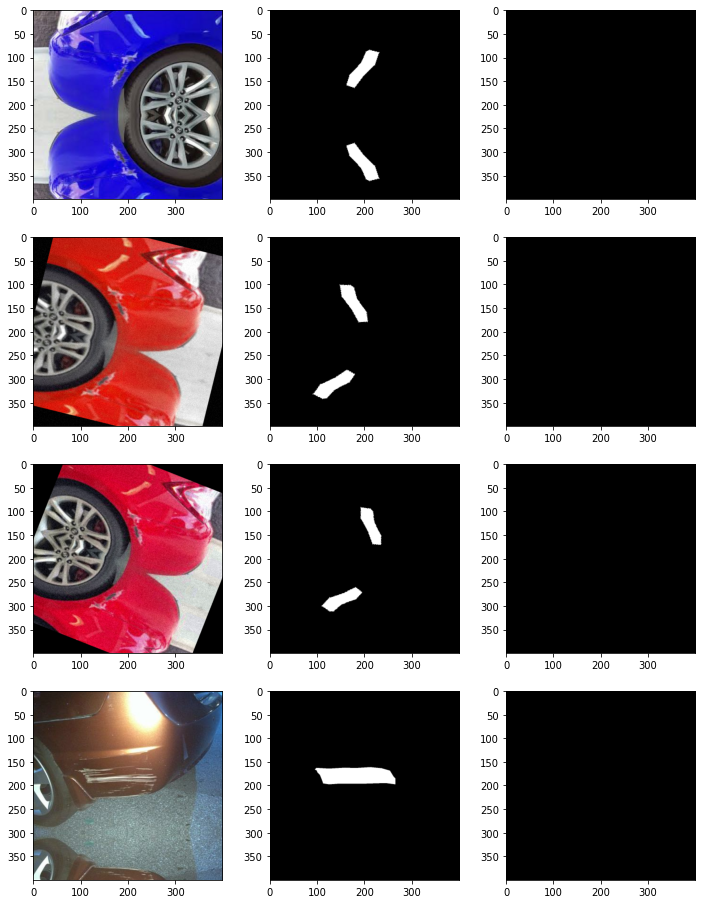

In [ ]:
num_example_to_display = 4

fig, axs = plt.subplots(nrows=num_example_to_display, ncols=3, figsize=(12,4*num_example_to_display))
  
for i in range(num_example_to_display):
  axs[i][0].imshow(val_img[i]);
  axs[i][1].imshow(np.squeeze(val_mask[i],-1), cmap='gray');
  axs[i][2].imshow(np.squeeze(pred_mask[i],-1), cmap='gray')

## 4. Evaluating the Results

further considerations
using pretrained model
using images without damage


possible challanges